In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, SpatialDropout2D, ELU
from keras.layers import Convolution2D, MaxPooling2D, Cropping2D
from keras.layers.core import Lambda

from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import np_utils

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import cv2

In [121]:
zero = driving_csv[driving_csv["steering"] == 0]
print("Samples taken out: ", len(zero) // 2)
zeros_half = zero.sample(frac=0.5)
nonzero = driving_csv[driving_csv["steering"] != 0]
reduced_dataset = pd.concat([zeros_half, nonzero])
reduced_dataset.to_csv("data-udacity/driving_log_reduced.csv")

Number of datapoints: 8036
Images: 3
Sample image
Image shape:  (160, 320, 3)


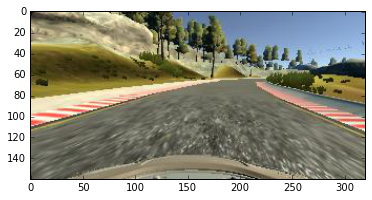

In [60]:
# Option C: Three images

## Import data
# Added header row manually to CSV.
driving_csv = pd.read_csv("data-udacity/driving_log.csv")

# Examine data
print("Number of datapoints: %d" % len(driving_csv))
driving_csv.head()

driving_csv_up_to_3600 = driving_csv[:3600]
driving_csv_up_to_10 = driving_csv[:10]
driving_csv_from_3700 = driving_csv[3700:]

steer_left = driving_csv_up_to_3600[driving_csv_up_to_3600["steering"] < -0.9]
steer_right = driving_csv_from_3700[driving_csv_from_3700["steering"] > 0.7]
steer_zero = driving_csv_up_to_10[driving_csv_up_to_10["speed"] > 22]

three_images = pd.concat([steer_right, 
                          steer_left, 
                          steer_zero])

# Extract centre image and steering angle from table
# Format: X_path: centre image name, y: steeringa angle
X_path = [three_images.iloc[i]["center"] \
              for i in range(len(three_images))]
y = [three_images.iloc[i]["steering"] \
              for i in range(len(three_images))]

# Import images
X_images = [mpimg.imread("data-udacity/" + image_path) for image_path in X_path]

# View image
print("Images: %d" % len(X_images))
print("Sample image")
plt.imshow(X_images[0])
# X_images[0]

imshape = X_images[0].shape
print("Image shape: ", imshape)

X_train = np.array(X_images)
y_train = np.array(y)

X_val = np.array(X_images)
y_val = np.array(y)

### Generator

In [110]:
import os
import csv

samples = []
with open('data-udacity/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)

samples = samples[1:]
        
from sklearn.model_selection import train_test_split
train_samples, validation_samples = train_test_split(samples, test_size=0.2)

In [113]:
def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                name = './data-udacity/IMG/'+batch_sample[0].split('/')[-1]
                center_image = cv2.imread(name)
                center_angle = float(batch_sample[3])
                images.append(center_image)
                angles.append(center_angle)

            X_train = np.array(images)
            y_train = np.array(angles)
            
            # print("X_train: ", X_train)
            # print("y_train: ", y_train)
            yield shuffle(X_train, y_train)

# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)

### Models

In [20]:
def resize(image):
    import tensorflow as tf  # This import is required here otherwise the model cannot be loaded in drive.py
    return tf.image.resize_images(image, 66, 200)

In [74]:
# NVIDIA End to End Learning Pipeline Model

model = Sequential()

# Crop the images
# TODO: I think the cropping coords here are wrong. height should be 105.6
# to preserve aspect ratio.
model.add(Cropping2D(cropping=((50, 20), (0, 0)),
                     dim_ordering='tf', # default
                     input_shape=(160, 320, 3)))

# Resize the data
model.add(Lambda(resize))

# Normalise data
# TODO: some people use /255.0 - 0.5. Why?
model.add(Lambda(lambda x: x/127.5 - 1.))

# Conv layer 1, 5x5 kernel to 24@ (from 3@)
# TODO: What does the number of filters MEAN?
# Stride of 2x2
model.add(Convolution2D(24, 36, 104,
                        input_shape=(66,200))
         )

model.add(Activation('elu'))
model.add(SpatialDropout2D(0.1))

# Conv layer 2, 5x5 kernel to 36@
model.add(Convolution2D(36, 18, 50))
model.add(Activation('elu'))
model.add(SpatialDropout2D(0.1))

# Conv layer 3, 5x5 kernel to 48@
model.add(Convolution2D(48, 10, 32))
model.add(Activation('elu'))
model.add(SpatialDropout2D(0.1))

# Conv layer 4, 3x3 kernel to 64@
model.add(Convolution2D(64, 3, 12))
model.add(Activation('elu'))
model.add(SpatialDropout2D(0.1))

# Conv layer 5, 3x3 kernel to 64@
model.add(Convolution2D(64, 3, 3))
model.add(Activation('elu'))
model.add(SpatialDropout2D(0.1))

# Flatten
model.add(Flatten())

# Removed: fully connected layer 1, 1164 neurons

# Fc2, 100 neurons
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.1))

# Fc3, 50 neurons
model.add(Dense(50))
model.add(Activation('relu'))
model.add(Dropout(0.1))

# Fc4, 10 neurons
model.add(Dense(10))
model.add(Activation('relu'))
model.add(Dropout(0.1))

# Output
model.add(Dense(1, activation="tanh"))

# Compile model
# sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
adam = Adam(lr=0.0001)
model.compile(loss='mean_squared_error',
              optimizer=adam,
              metrics=['accuracy'])

model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
cropping2d_37 (Cropping2D)       (None, 90, 320, 3)    0           cropping2d_input_37[0][0]        
____________________________________________________________________________________________________
lambda_72 (Lambda)               (None, 66, 200, 3)    0           cropping2d_37[0][0]              
____________________________________________________________________________________________________
lambda_73 (Lambda)               (None, 66, 200, 3)    0           lambda_72[0][0]                  
____________________________________________________________________________________________________
convolution2d_162 (Convolution2D (None, 31, 97, 24)    269592      lambda_73[0][0]                  
___________________________________________________________________________________________

In [76]:
model = Sequential()

# Crop 50 pixels from the top of the image and 20 from the bottom
model.add(Cropping2D(cropping=((50, 20), (0, 0)),
                     dim_ordering='tf', # default
                     input_shape=(160, 320, 3)))
 
# Resize the data
model.add(Lambda(resize))

model.add(Lambda(lambda x: (x/127.5) - 1.))

model.add(Convolution2D(16, 8, 8, subsample=(4, 4), border_mode="same"))
model.add(ELU())

model.add(Convolution2D(32, 5, 5, subsample=(2, 2), border_mode="same"))
model.add(ELU())

model.add(Convolution2D(64, 5, 5, subsample=(2, 2), border_mode="same"))

model.add(Flatten())
model.add(Dropout(.2))
model.add(ELU())

model.add(Dense(512))
model.add(Dropout(.5))
model.add(ELU())

model.add(Dense(1))

model.compile(optimizer="adam", loss="mse", metrics=['accuracy'])

model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
cropping2d_38 (Cropping2D)       (None, 90, 320, 3)    0           cropping2d_input_38[0][0]        
____________________________________________________________________________________________________
lambda_74 (Lambda)               (None, 66, 200, 3)    0           cropping2d_38[0][0]              
____________________________________________________________________________________________________
lambda_75 (Lambda)               (None, 66, 200, 3)    0           lambda_74[0][0]                  
____________________________________________________________________________________________________
convolution2d_167 (Convolution2D (None, 17, 50, 16)    3088        lambda_75[0][0]                  
___________________________________________________________________________________________

Data preprocessing reference: [Geoff Breemer](https://carnd-forums.udacity.com/questions/36045049/answers/36047341)

### Train model

In [105]:
# Train model
batch_size = 5
nb_epoch = 30
# data_augmentation = True

model.fit(X_train, y_train,
              batch_size=batch_size,
              nb_epoch=nb_epoch,
              # validation_split=0.1,
              validation_data=(X_val, y_val),
              # shuffle=True
         )

Train on 3 samples, validate on 3 samples
Epoch 1/30
3/3 [==============================] - 0s - loss: 0.0199 - acc: 0.3333 - val_loss: 0.0320 - val_acc: 0.3333
Epoch 2/30
3/3 [==============================] - 0s - loss: 0.0673 - acc: 0.3333 - val_loss: 0.0179 - val_acc: 0.3333
Epoch 3/30
3/3 [==============================] - 0s - loss: 0.0545 - acc: 0.3333 - val_loss: 9.9427e-04 - val_acc: 0.3333
Epoch 4/30
3/3 [==============================] - 0s - loss: 0.0035 - acc: 0.3333 - val_loss: 0.0075 - val_acc: 0.3333
Epoch 5/30
3/3 [==============================] - 0s - loss: 0.0134 - acc: 0.3333 - val_loss: 0.0231 - val_acc: 0.3333
Epoch 6/30
3/3 [==============================] - 0s - loss: 0.0089 - acc: 0.3333 - val_loss: 0.0347 - val_acc: 0.3333
Epoch 7/30
3/3 [==============================] - 0s - loss: 0.0143 - acc: 0.3333 - val_loss: 0.0362 - val_acc: 0.3333
Epoch 8/30
3/3 [==============================] - 0s - loss: 0.0852 - acc: 0.3333 - val_loss: 0.0185 - val_acc: 0.3333
Ep

In [ ]:
# Train model
batch_size = 32
nb_epoch = 20
# data_augmentation = True
 
model.fit_generator(train_generator, 
                    samples_per_epoch=len(train_samples), 
                    validation_data=validation_generator,
                    nb_val_samples=len(validation_samples), nb_epoch=nb_epoch)

Epoch 1/20
 896/6428 [===>..........................] - ETA: 25s - loss: 0.0081 - acc: 0.5469

In [122]:
from keras.models import model_from_json

model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
    
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk
